#### Table of contents
- Importing libraries
- Loading datasets
- Feature Engineering
- Cross validation
- Model training
- Model evaluation
- Summary

#### Importing libraries


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import model_selection
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_error,r2_score
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from scipy.stats import boxcox
import os
%matplotlib inline
import optuna
from functools import partial
import warnings
warnings.filterwarnings("ignore")
np.random.seed(365)

#### Loading datasets

In [22]:
#load datasets
data_path_train = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Data\Housing_dataset_train.csv"
df_train = pd.read_csv(data_path_train)
data_path_test = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Data\Housing_dataset_test.csv"
df_test = pd.read_csv(data_path_test)
test = df_test.copy()

In [23]:
df_train.shape

(14000, 7)

#### Feature Engineering

In [24]:
#Drop missing values in selected features
df_train.dropna(subset=["loc","title","bedroom"],inplace=True)
df_train.shape

(8856, 7)

##### Filling missing values

In [25]:

def group_feature_by_feature_based_on_mode(by_feature,feature,df):
    modes_values = []
    titles = list(df[by_feature].unique())
    for title in titles:
        new_df = df[df[by_feature] == title]
        mode_value =  new_df[feature].mode()[0]
        modes_values.append(mode_value)
    mode_dict = dict(zip(titles, modes_values))
    print(mode_dict)

    return mode_dict
#Fill missing values in bathroon by mode value of house title
mode_values = group_feature_by_feature_based_on_mode(by_feature = "title",feature="bathroom",df=df_train)

#fill missing values by mode house title
def fill_missing_by_mode(cols,mode_dict=mode_values):
    col1 = cols[0]
    col2 = cols[1]
    if pd.isnull(col2):
        return mode_dict[col1]
    else:
        return col2


df_train["bathroom"] = df_train[["title","bathroom"]].apply(fill_missing_by_mode,axis = 1)

#Fill missing values in parking space  by mode value of house titl
mode_values = group_feature_by_feature_based_on_mode(by_feature = "title",feature="parking_space",df=df_train)
df_train["parking_space"] = df_train[["title","parking_space"]].apply(fill_missing_by_mode,axis = 1)

print(f"Total missing data in train data is {df_train.isnull().sum().sum()}")
print(f"Total missing data in test data  is {df_test.isnull().sum().sum()}")

{'Semi-detached duplex': 2.0, 'Detached duplex': 1.0, 'Penthouse': 2.0, 'Bungalow': 2.0, 'Apartment': 1.0, 'Terrace duplex': 1.0, 'Townhouse': 1.0, 'Mansion': 1.0, 'Flat': 2.0, 'Cottage': 1.0}
{'Semi-detached duplex': 3.0, 'Detached duplex': 3.0, 'Penthouse': 4.0, 'Bungalow': 4.0, 'Apartment': 4.0, 'Terrace duplex': 4.0, 'Townhouse': 1.0, 'Mansion': 1.0, 'Flat': 2.0, 'Cottage': 1.0}
Total missing data in train data is 0
Total missing data in test data  is 0


##### Creating new features

In [26]:
#create new feature to inducate geopolitical zone
geo_states = {"North_central":["Benue","Kogi", "Kwara", "Nasarawa", "Niger", "Plateau"],
"North_East":["Adamawa", "Bauchi", "Borno", "Gombe", "Taraba", "Yobe"],
"North_West":["Kaduna", "Katsina", "Kano", "Kebbi", "Sokoto", "Jigawa","Zamfara"],
"South_East":["Abia", "Anambra", "Ebonyi", "Enugu", "Imo"],
"South":["Akwa Ibom", "Bayelsa", "Cross River", "Delta", "Edo", "Rivers"],
"South_West":["Ekiti", "Lagos", "Osun", "Ondo", "Ogun", "Oyo"]}

def add_geo_zone(df_train):
        df_train["Geo_zone"] = df_train["loc"]
        df_train.loc[df_train["loc"].isin(geo_states["North_central"]),"Geo_zone"] = "North_central"
        df_train.loc[df_train["loc"].isin(geo_states["North_East"]),"Geo_zone"] = "North_East"
        df_train.loc[df_train["loc"].isin(geo_states["North_West"]),"Geo_zone"] = "North_West"
        df_train.loc[df_train["loc"].isin(geo_states["South_East"]),"Geo_zone"] = "South_East"
        df_train.loc[df_train["loc"].isin(geo_states["South"]),"Geo_zone"] = "South"
        df_train.loc[df_train["loc"].isin(geo_states["South_West"]),"Geo_zone"] = "South_West"
        return df_train
df_train = add_geo_zone(df_train = df_train)
df_test = add_geo_zone(df_train = df_test)

##### Encoding categorical features

In [27]:
#Taking square root, cube root and logging output feature to normalize output- We can select any of the options as target variable
df_train["price_log"] = np.log(df_train["price"] + 1)
df_train["price_sqrt"] = np.sqrt(df_train["price"])
df_train["price_cube"] = np.cbrt(df_train["price"])

In [28]:
#Encode house location based mean houe price ranking
#avergae pricing based on location
location_ranks = list(df_train.groupby(["loc"])["price_log"].mean().sort_values(ascending=False).index)
location_ranks_vals = list(df_train.groupby(["loc"])["price_log"].mean().sort_values(ascending=False).values)
location_ranks_dict = {}
for i,j in zip(location_ranks,location_ranks_vals):
    location_ranks_dict[i] = j
print(location_ranks_dict)
# Use the map() function to encode the data
categories_train = df_train["loc"]
categories_test = df_test["loc"]
encoded_data_train = categories_train.map(location_ranks_dict)
encoded_data_test = categories_test.map(location_ranks_dict)

#replace encoded data for both train and test data
df_train["loc"] = encoded_data_train
df_test["loc"] = encoded_data_test

{'Lagos': 15.164201750440764, 'Bayelsa': 14.886269812374607, 'Rivers': 14.807672123027194, 'Akwa Ibom': 14.743598986159991, 'Delta': 14.7148367100054, 'Ogun': 14.688530952997048, 'Cross River': 14.66378009139607, 'Anambra': 14.586379546363371, 'Oyo': 14.583855080167194, 'Edo': 14.578549286833502, 'Enugu': 14.569031980098126, 'Ondo': 14.55682652657201, 'Osun': 14.51749451121393, 'Ekiti': 14.513425575326508, 'Kano': 14.481509449571682, 'Nasarawa': 14.456433601921779, 'Imo': 14.442751966809734, 'Katsina': 14.41534982377515, 'Plateau': 14.389817938226313, 'Benue': 14.385893546358306, 'Kwara': 14.379143188461923, 'Adamawa': 14.375183993010024, 'Taraba': 14.365381784406637, 'Niger': 14.365256701446995, 'Kaduna': 14.36002146533926, 'Gombe': 14.33417112850962, 'Kogi': 14.30886528345092, 'Bauchi': 14.283238132256606, 'Yobe': 14.28075491158785, 'Jigawa': 14.27540458344726, 'Borno': 14.272336809801947, 'Abia': 14.271971038099514, 'Zamfara': 14.268366027934789, 'Sokoto': 14.247858492020116, 'Ebony

In [29]:
#Encode house location based mean houe price ranking
#avergae pricing based on location
location_ranks = list(df_train.groupby(["title"])["price_log"].mean().sort_values(ascending=False).index)
location_ranks_vals = list(df_train.groupby(["title"])["price_log"].mean().sort_values(ascending=False).values)
location_ranks_dict = {}
for i,j in zip(location_ranks,location_ranks_vals):
    location_ranks_dict[i] = j
print(location_ranks_dict)

# Use the map() function to encode the data
categories_train = df_train["title"]
categories_test = df_test["title"]
encoded_data_train = categories_train.map(location_ranks_dict)
encoded_data_test = categories_test.map(location_ranks_dict)

#replace encoded data for both train and test data
df_train["title"] = encoded_data_train
df_test["title"] = encoded_data_test

{'Mansion': 15.038973416880724, 'Penthouse': 14.728088824321503, 'Detached duplex': 14.556294050503396, 'Townhouse': 14.46983941963301, 'Terrace duplex': 14.401258616672163, 'Semi-detached duplex': 14.39968496038179, 'Flat': 14.301541574931527, 'Bungalow': 14.299494067095424, 'Apartment': 14.207836267874152, 'Cottage': 14.010785242580935}


In [30]:
#Encode house geopolotical zone  based mean houe price ranking
#avergae pricing based on title
location_ranks = list(df_train.groupby(["Geo_zone"])["price_log"].mean().sort_values(ascending=False).index)
location_ranks_vals = list(df_train.groupby(["Geo_zone"])["price_log"].mean().sort_values(ascending=False).values)
location_ranks_dict = {}
for i in location_ranks:
    location_ranks_dict[i] = location_ranks.index(i) + 1
print(location_ranks_dict)
# Use the map() function to encode the data
categories_train = df_train["Geo_zone"]
categories_test = df_test["Geo_zone"]
encoded_data_train = categories_train.map(location_ranks_dict)
encoded_data_test = categories_test.map(location_ranks_dict)

#replace encoded data for both train and test data
df_train["Geo_zone"] = encoded_data_train
df_test["Geo_zone"] = encoded_data_test

{'South': 1, 'South_West': 2, 'South_East': 3, 'North_central': 4, 'North_West': 5, 'North_East': 6}


In [31]:
#Converting bedroom,bathroom and parking space to discrete variables
df_train[["bedroom","bathroom","parking_space"]] = df_train[["bedroom","bathroom","parking_space"]].astype(int)
df_test[["bedroom","bathroom","parking_space"]] = df_test[["bedroom","bathroom","parking_space"]].astype(int)

#### Adding more informative features

In [32]:
#Adding total number of bedrooms,bathrooms and parking space
df_train["bed_bath_paking"] =  df_train["bedroom"] + df_train["bathroom"] + df_train["parking_space"]
df_test["bed_bath_paking"] =  df_test["bedroom"] + df_test["bathroom"] + df_test["parking_space"]

#compare ratio of parking_space to bedroom
df_train["parking_bedroom_ratio"] =  df_train["parking_space"] /  df_train["bedroom"]
df_test["parking_bedroom_ratio"] =  df_test["parking_space"] / df_test["bedroom"]

#Adding ranking of loaction and house title as a feature
df_train["Rank_loc"] = df_train["loc"] + df_train["title"]
df_test["Rank_loc"] = df_test["loc"] +  df_test["title"]
df_train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price,Geo_zone,price_log,price_sqrt,price_cube,bed_bath_paking,parking_bedroom_ratio,Rank_loc
0,3583,14.415350,14.399685,2,2,1,1149999.565,5,13.955273,1072.380327,104.768942,5,0.500000,28.815035
3,2224,14.586380,14.556294,5,2,4,2410306.756,3,14.695265,1552.516266,134.077974,11,0.800000,29.142674
7,3003,14.415350,14.728089,3,3,5,2043107.592,5,14.529983,1429.373147,126.890881,11,1.666667,29.143439
10,12573,14.688531,14.299494,1,2,6,1330213.036,2,14.100850,1153.348619,109.978316,9,6.000000,28.988025
11,2624,14.886270,14.207836,3,4,2,1891772.069,1,14.453025,1375.417053,123.677188,9,0.666667,29.094106


#### Cross Validation

In [33]:
#Calculate the number of bins using the Sturges method
bins = int(np.ceil(np.log2(len(df_train)) + 1))
#Bin the data using the Sturges method
binned_data = pd.cut(df_train["price_log"], bins=bins,labels=False)
df_train["Bin_value"] = binned_data

In [34]:
#dictionary of models to be used
models = {"Linear_Regression":LinearRegression(),
          "light_gradient_boistingt":lgb.LGBMRegressor(random_state=0,verbose=0),"XGboost":xgb.XGBRegressor(random_state=0),
          "Catboost":CatBoostRegressor(random_state=0,silent=True),"Gradient_boosting":GradientBoostingRegressor(random_state=0)}

#Divid data into dependent and independent variables
X = df_train.drop(["Bin_value","price","price_log","ID","price_sqrt","price_cube"],axis=1)
#scale_features = ["Rank_loc","parking_bedroom_ratio","bed_bath_paking"]
#use_cols = ['Rank_loc','title','bedroom','bed_bath_paking','loc','bathroom','parking_bedroom_ratio','Geo_zone']
X = df_train[["title","bedroom","bathroom","loc","bed_bath_paking","Rank_loc","parking_space","parking_bedroom_ratio"]]
cols = X.columns
y = df_train["Bin_value"]
target = "price_log"
#skf = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

#Custom cross validation function
def run(models):
    #create empty dic for model and scores
    scores = {}
    for model in models.keys():
        scores[model] = [] #create empty lsit to store model scores at on each fold
    for name,model in models.items():
        print(f"Running -- {name}")
        print("-------------------------")
        for i,(train_index, test_index) in enumerate(skf.split(X, y)):
            xtrain, xvalid = X.iloc[train_index], X.iloc[test_index]
            ytrain, yvalid = df_train[target].iloc[train_index], df_train[target].iloc[test_index]
            model.fit(xtrain, ytrain)
            yvalid = np.exp(yvalid) - 1
            #make predictions on validation data
            preds_valid =  np.exp(model.predict(xvalid)) - 1
            rmse = mean_squared_error(yvalid, preds_valid,squared=False)
            print(f"Fold {i} score : ", rmse)
            scores[name].append(rmse)
        print(f"{model} -- mean rmse {np.mean(scores[name])}")
        print()

    #take the mean of scores for every model
    for name, model in models.items():
        scores[name] = np.mean(np.array(scores[name]))
    model_names = scores.keys()
    model_scores = scores.values()
    results = {"Model":model_names,"Rmse_score":model_scores}
    results = pd.DataFrame.from_dict(results) #create dictionary of model and corresponding mean rmse score
    return results

In [16]:
results = run(models = models)

Running -- Linear_Regression
-------------------------
Fold 0 score :  472386.4667989548
Fold 1 score :  469054.80779245583
Fold 2 score :  489426.90818323346
Fold 3 score :  410419.36400547874
Fold 4 score :  318203.9651273731
Fold 5 score :  382665.23556789954
Fold 6 score :  343563.1644095684
Fold 7 score :  320688.94501199917
Fold 8 score :  332425.52569075266
Fold 9 score :  378950.2848654802
LinearRegression() -- mean rmse 391778.4667453196

Running -- light_gradient_boistingt
-------------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
Fold 0 score :  421318.15738206403
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
Fold 1 score :  455709.72850581195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

In [17]:
sorted_df = results.sort_values(by="Rmse_score",ascending=True)
sorted_df.head()

,Model,Rmse_score
4,Gradient_boosting,367148.845194
1,light_gradient_boistingt,372179.046952
3,Catboost,389999.180707
0,Linear_Regression,391778.466745
2,XGboost,410578.889002


### Model Training
Trainning and predicting on test data for submissions

In [19]:
def train_predict(model):
    scores = []
    final_predictions = []
    for i,(train_index, test_index) in enumerate(skf.split(X, y)):
        xtrain, xvalid = X.iloc[train_index], X.iloc[test_index]
        ytrain, yvalid = df_train[target].iloc[train_index], df_train[target].iloc[test_index]
        xtest = df_test[cols].copy()

        #Fit model
        model.fit(xtrain, ytrain)
        yvalid = np.exp(yvalid) - 1
        #make predictions on validation data
        preds_valid =  np.exp(model.predict(xvalid)) - 1


        #make prediction on test data
        test_preds = np.exp(model.predict(xtest))  - 1
        final_predictions.append(test_preds)
        rmse = mean_squared_error(yvalid, preds_valid,squared=False)
        print(f"Fold {i} score : ", rmse)
        scores.append(rmse)

    print(f"Mean rmse :{np.array(scores).mean()}")
    return final_predictions

In [20]:
#Traing and predict with gradient boosting and xgboost averaging
gb_model_1 = GradientBoostingRegressor(random_state=0,criterion="squared_error")
preds_gb = train_predict(gb_model_1);
preds_gb= np.mean(np.column_stack(preds_gb),axis=1)
sub = test[["ID"]]
sub["price_gb"] = preds_gb

#Train and predict with xgboost
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.08,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 2,
    'eval_metric': 'rmse',
    'seed': 42,
    "n_estimators":180
}
model_xgb = xgb.XGBRegressor(**params)
xgb_preds = train_predict(model_xgb);
preds_xgb= np.mean(np.column_stack(xgb_preds),axis=1)
sub["price_xgb"] = preds_xgb

#Take mean of the two models
sub["price"] = (sub["price_gb"] + sub["price_xgb"])/2
sub = sub.drop(columns = ["price_gb","price_xgb"],axis=1)
sub.head()

Fold 0 score :  413618.02128258324
Fold 1 score :  455216.5860762568
Fold 2 score :  448164.3477517177
Fold 3 score :  411047.32730795944
Fold 4 score :  280066.11321522336
Fold 5 score :  417121.3562574586
Fold 6 score :  320326.99503298645
Fold 7 score :  277540.7364441827
Fold 8 score :  288042.9383388407
Fold 9 score :  360344.0302320844
Mean rmse :367148.84519392933
Fold 0 score :  413492.93021513504
Fold 1 score :  436421.9860439058
Fold 2 score :  449858.4767551741
Fold 3 score :  396505.8695726413
Fold 4 score :  280363.16291524714
Fold 5 score :  403188.91951122554
Fold 6 score :  313706.139194949
Fold 7 score :  290210.5155081594
Fold 8 score :  286257.9893556265
Fold 9 score :  339586.77199613414
Mean rmse :360959.2761068198


,ID,price
0,845,2.434138e+06
1,1924,1.019580e+06
2,10718,1.247990e+06
3,12076,9.187253e+06
4,12254,1.821341e+06


In [21]:
#save submission file
path = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Submissions"
os.chdir(path)
sub.to_csv("xgb_gradient_boosting_mean.csv",index=False)

In [18]:
#Combine catboost and gradient boosting
def train_predict(model):
    scores = []
    final_predictions = []
    for i,(train_index, test_index) in enumerate(skf.split(X, y)):
        xtrain, xvalid = X.iloc[train_index], X.iloc[test_index]
        ytrain, yvalid = df_train[target].iloc[train_index], df_train[target].iloc[test_index]
        xtest = df_test[cols].copy()

        #Fit model
        model.fit(xtrain, ytrain)
        yvalid = np.exp(yvalid) - 1
        #make predictions on validation data
        preds_valid =  np.exp(model.predict(xvalid)) - 1


        #make prediction on test data
        test_preds = np.exp(model.predict(xtest))  - 1
        final_predictions.append(test_preds)
        rmse = mean_squared_error(yvalid, preds_valid,squared=False)
        print(f"Fold {i} score : ", rmse)
        scores.append(rmse)

    print(f"Mean rmse :{np.array(scores).mean()}")
    return final_predictions
#Traing and predict with gradient boosting
gb_model_1 = GradientBoostingRegressor(random_state=0,criterion="squared_error")
preds_gb = train_predict(gb_model_1);
preds_gb= np.mean(np.column_stack(preds_gb),axis=1)
sub = test[["ID"]]
sub["price_gb"] = preds_gb

#Train and predict with xgboost
params = {
'learning_rate': 0.08,
    'iterations': 150,
    'depth': 6,
    'subsample': 0.8,
    'colsample_bylevel': 0.4,
    'l2_leaf_reg': 2.0,
    'min_data_in_leaf': 1,
    'border_count': 32,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 10,
    "silent":True

}
model_cat = CatBoostRegressor(random_state=0,silent=True)
cat_preds = train_predict(model_cat);
preds_cat= np.mean(np.column_stack(cat_preds),axis=1)
sub["price_cat"] = preds_cat

#Take mean of the two models
sub["price"] = (sub["price_gb"] + sub["price_cat"])/2
sub = sub.drop(columns = ["price_gb","price_cat"],axis=1)
sub.head()

Fold 0 score :  413618.02128258324
Fold 1 score :  455216.5860762568
Fold 2 score :  448164.3477517177
Fold 3 score :  411047.32730795944
Fold 4 score :  280066.11321522336
Fold 5 score :  417121.3562574586
Fold 6 score :  320326.99503298645
Fold 7 score :  277540.7364441827
Fold 8 score :  288042.9383388407
Fold 9 score :  360344.0302320844
Mean rmse :367148.84519392933
Fold 0 score :  470443.8480762587
Fold 1 score :  508899.9571187958
Fold 2 score :  459849.8589434556
Fold 3 score :  411512.55981958675
Fold 4 score :  295708.83822009113
Fold 5 score :  414503.38291511097
Fold 6 score :  330114.2133052996
Fold 7 score :  315693.6480445226
Fold 8 score :  294218.19942609343
Fold 9 score :  399047.30120420904
Mean rmse :389999.1807073424


,ID,price
0,845,2.393337e+06
1,1924,1.024215e+06
2,10718,1.246687e+06
3,12076,8.435275e+06
4,12254,1.860347e+06


In [20]:
#save submission file
path = r"C:\Users\User\Desktop\Blessing_AI\Free_AI_Classes_2023\Submissions"
os.chdir(path)
sub.to_csv("gb_cat.csv",index=False)

#### Training Best Model 
-Training best model - xgboost after parameter optimization

### Feature Importance

Feature importance generation

In [35]:
#get feature importance from model
feature_importances = gb_model_1.feature_importances_

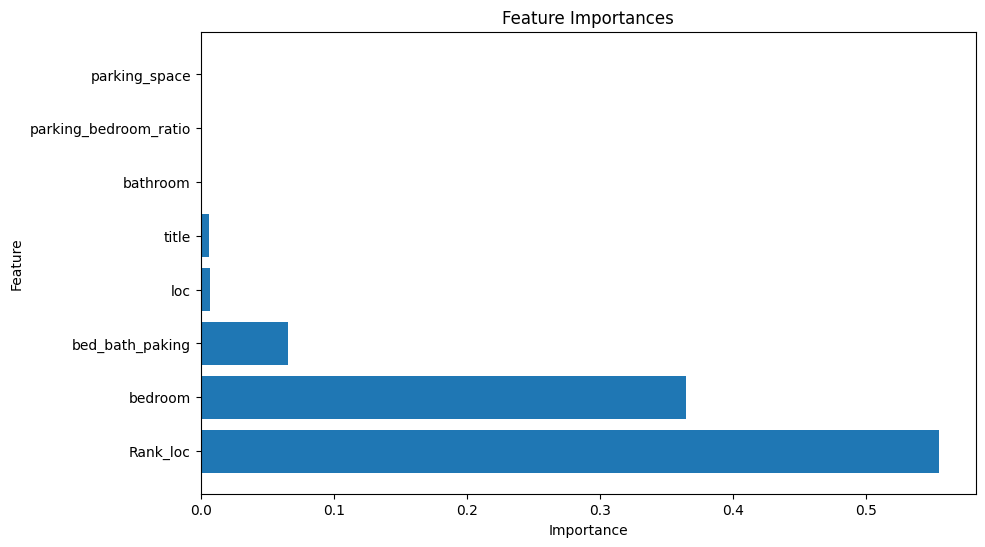

In [36]:
# Create a DataFrame to store the feature names and importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

Comment : The feature importance from the model shows number of bedrooms,sum of ranking of location and house title  ,sum of bedroom plus bathroom plus parking are the most significant when predicting the price of an house with the trained model